In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = Path.cwd().resolve().parent / "datos"

datos_titanic = pd.read_parquet(DATA_DIR / "02_datos_con_tipo_de_dato_ajustado_titanic.parquet")

In [3]:
datos_titanic.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

In [4]:
from sklearn.model_selection import train_test_split


X = datos_titanic.drop(columns=["survived"])
y = datos_titanic["survived"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


numeric_features = ["age", "fare", "sibsp", "parch"]
categorical_features = ["embarked", "sex"]
ordinal_features = ["pclass"]


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[[1, 2, 3]]))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [7]:
from flaml import AutoML
from sklearn.pipeline import Pipeline as SKLearnPipeline

automl = AutoML()

In [9]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

X_test_preprocessed = preprocessor.fit_transform(X_test)

automl_settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # task type
    "estimator_list": ['lgbm', 'xgboost', 'lrl1', 'rf'],  # list of ML learners
    "log_file_name": 'flaml_titanic_automl.log',  # flaml log file
    "seed": 42
}

automl.fit(X_train_preprocessed, y_train, **automl_settings)

[flaml.automl.logger: 10-21 19:28:44] {1752} INFO - task = classification
[flaml.automl.logger: 10-21 19:28:44] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-21 19:28:44] {1862} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 10-21 19:28:44] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'lrl1', 'rf']
[flaml.automl.logger: 10-21 19:28:44] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-21 19:28:44] {2417} INFO - Estimated sufficient time budget=472s. Estimated necessary time budget=8s.
[flaml.automl.logger: 10-21 19:28:44] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2034,	best estimator lgbm's best error=0.2034
[flaml.automl.logger: 10-21 19:28:44] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-21 19:28:44] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2034,	best estimator lgbm's best error=0.2034
[flaml.automl.logger: 10-21 19:28:44] {2282} INFO - iteration 2, cur

In [11]:
print("Mejor modelo encontrado", automl.best_estimator)

print("\n")

print("Mejor configuración de hiperparámetros:", automl.best_config)

print("\n")

print("Tiempo de búsqueda:", automl.time_to_find_best_model, "segundos")

Mejor modelo encontrado xgboost


Mejor configuración de hiperparámetros: {'n_estimators': 13, 'max_leaves': 4, 'min_child_weight': 2.0201347507194547, 'learning_rate': 0.5103467703938295, 'subsample': 0.9926890729861031, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9471578937886543, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.7675743574278889}


Tiempo de búsqueda: 43.938682079315186 segundos


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = automl.predict(X_test_preprocessed)

y_pred_proba = automl.predict_proba(X_test_preprocessed)[:, 1]

In [16]:
test_accuracy = accuracy_score(y_test, y_pred)

print("\n")

print(classification_report(y_test, y_pred, target_names=["No sobrevivió", "Sobrevivió"]))



               precision    recall  f1-score   support

No sobrevivió       0.73      0.94      0.82       144
   Sobrevivió       0.88      0.58      0.70       118

     accuracy                           0.77       262
    macro avg       0.81      0.76      0.76       262
 weighted avg       0.80      0.77      0.77       262



<Axes: >

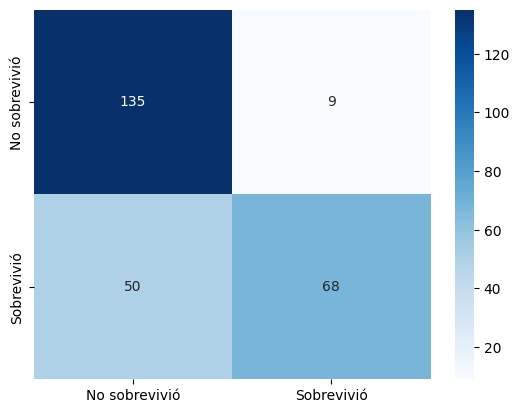

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No sobrevivió", "Sobrevivió"], yticklabels=["No sobrevivió", "Sobrevivió"])

In [22]:
df_predictions = X_test.copy()

In [23]:
X_test

,pclass,sex,age,sibsp,parch,fare,embarked
1148,3,male,35.0,0,0,7.1250,S
1049,3,male,20.0,1,1,15.7417,C
982,3,male,NaN,0,0,7.8958,S
808,3,male,NaN,0,0,8.0500,S
1195,3,male,NaN,0,0,7.7500,Q
...,...,...,...,...,...,...,...
572,2,female,28.0,0,0,12.6500,S
140,1,male,23.0,0,1,63.3583,C
1182,3,female,21.0,0,0,7.6500,S
312,1,male,50.0,1,1,211.5000,C


In [25]:
df_predictions["survived_real"] = y_test.values

df_predictions["prediction_label"] = y_pred

df_predictions["prediction_score"] = y_pred_proba

print(df_predictions[['pclass', 'sex', 'age', 'survived_real', 'prediction_label', 'prediction_score']].sample(4))

     pclass     sex   age  survived_real  prediction_label  prediction_score
247       1  female  54.0              1                 1          0.943922
894       3    male   4.0              1                 0          0.463336
680       3    male   NaN              0                 0          0.142725
297       1  female   NaN              1                 1          0.950427


# GUARDAR EL MODELO

In [26]:
full_pipeline = SKLearnPipeline(steps=[
    ("preprocessor", preprocessor),
    ("automl", automl.model)
])

print(full_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'fare', 'sibsp',
                                                   'parch']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[[1,
                                                                                               2,
                                                                         

In [27]:
import joblib 

model_filename = DATA_DIR / "xgb_flaml_automl_model.joblib"
joblib.dump(full_pipeline, model_filename)

['/Users/david.palacio/Documents/academia/titanic-prediccion/datos/xgb_flaml_automl_model.joblib']